# Lecture 14: Class demo

## Let's cluster images!!

![](../img/eva-fun-times.png)

For this demo, I'm going to use two image datasets: 
1. A small subset of [200 Bird Species with 11,788 Images](https://www.kaggle.com/datasets/veeralakrishna/200-bird-species-with-11788-images) (available [here](../data/birds.zip))
2. A tiny subset of [Food-101](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5)
(available [here](../data/food.zip))


To run the code below, you need to install pytorch and torchvision in the course conda environment. 

```conda install pytorch torchvision -c pytorch```

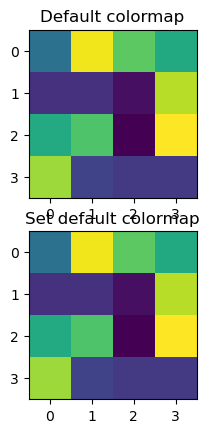

In [33]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions_unsup import *

In [6]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
import random

In [7]:
import torchvision

Let's start with  small subset of birds dataset. You can experiment with a bigger dataset if you like.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
set_seed(seed=42)

In [11]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [12]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [14]:
data_dir = "../data/birds"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
birds_inputs, birds_classes = read_img_dataset(data_dir)

In [15]:
X_birds = birds_inputs.numpy()

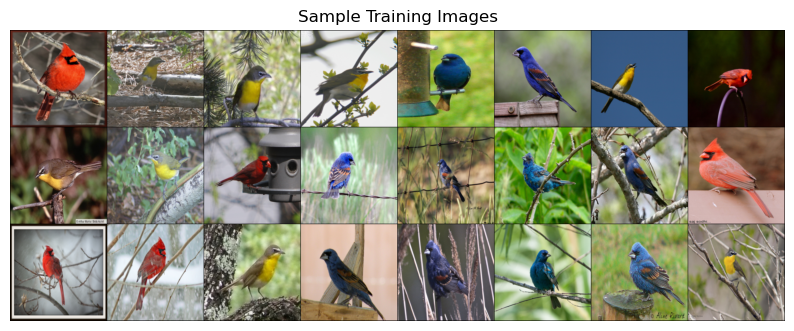

In [16]:
plot_sample_imgs(birds_inputs[0:24,:,:,:])

For clustering we need to calculate distances between points. So we need a vector representation for each data point. A simplest way to create a vector representation of an image is by flattening the image.  

In [18]:
flatten_transforms = transforms.Compose([
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),    
                    transforms.Lambda(torch.flatten)])
flatten_images = datasets.ImageFolder(root='../data/birds', transform=flatten_transforms)

In [19]:
flatten_dataloader = torch.utils.data.DataLoader(
        flatten_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )

In [20]:
flatten_train, y_train = next(iter(flatten_dataloader))

In [21]:
flatten_images = flatten_train.numpy()

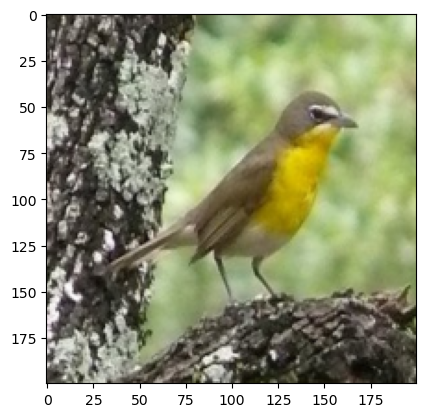

In [22]:
image_shape=[3,200,200]
img = flatten_images[20].reshape(image_shape)
plt.imshow(np.transpose(img / 2 + 0.5, (1, 2, 0)));

In [23]:
flatten_images.shape # 200 by 200 images with 3 color channels

(176, 120000)

In [26]:
from sklearn.cluster import KMeans
k = 3
km_flatten = KMeans(k, n_init='auto', random_state=123)
km_flatten.fit(flatten_images)

KMeans(n_clusters=3, n_init='auto', random_state=123)

In [27]:
km_flatten.cluster_centers_.shape

(3, 120000)

In [28]:
flatten_images.shape

(176, 120000)

In [29]:
unflatten_inputs = np.array([img.reshape(image_shape) for img in flatten_images])

Image indices:  [158  65  48 125  95]


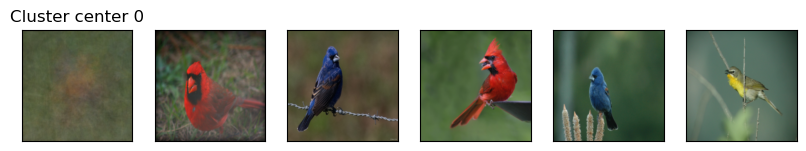

Image indices:  [165  94  77 152 108]


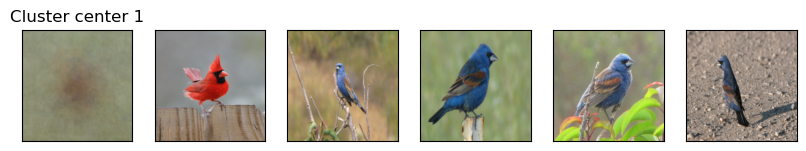

Image indices:  [156 100  25 133 121]


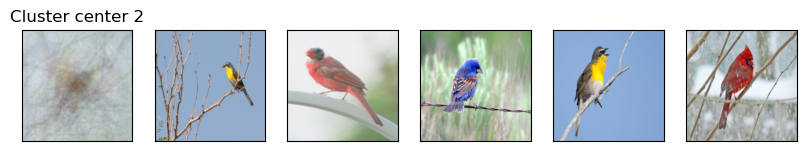

In [34]:
for cluster in range(k):
    get_cluster_images(km_flatten, flatten_images, unflatten_inputs, cluster, n_img=5)

We see some mis-categorizations. 

How about trying out a different input representation? Let's use transfer learning as a feature extractor with a pre-trained vision model. For each image in our dataset we'll pass it through a pretrained network and get a representation from the last layer, before the classification layer given by the pre-trained network. 

![](../img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

In [36]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_train = torch.cat((Z_train, model(inputs)), dim=0)
    return Z_train.detach()

In [37]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [38]:
Z_birds = get_features(
    densenet, birds_inputs, 
).numpy()

In [39]:
Z_birds.shape

(176, 1024)

Do we get better clustering with this representation? 

In [40]:
from sklearn.cluster import KMeans

k = 3
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_birds)

KMeans(n_clusters=3, n_init='auto', random_state=123)

In [41]:
km.cluster_centers_.shape

(3, 1024)

Image indices:  [ 31  15 171  72  53 174]


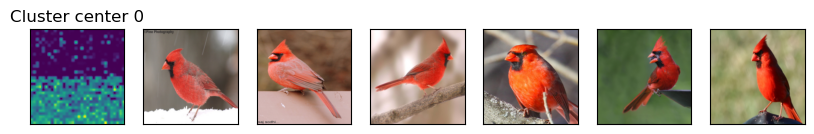

Image indices:  [ 69   5 120  58  36  61]


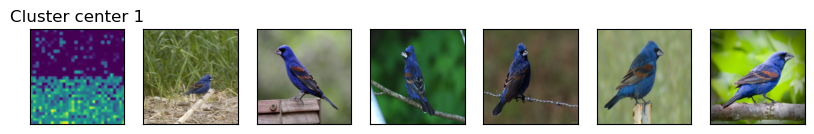

Image indices:  [162  48  23 134  18 127]


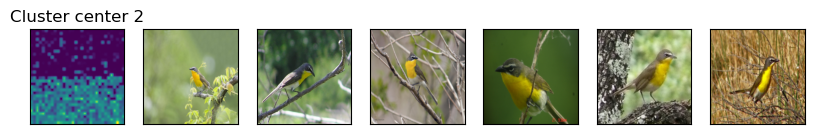

In [42]:
for cluster in range(k):
    get_cluster_images(km, Z_birds, X_birds, cluster, n_img=6)

KMeans seems to be doing a good job. But cluster centers are not interpretable at all now.
This dataset seems easier, as the birds have very distinct colors. Let's try a bit more complicated dataset.  

In [45]:
data_dir = "../data/food"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
food_inputs, food_classes = read_img_dataset(data_dir)
n_images

350

In [46]:
X_food = food_inputs.numpy()

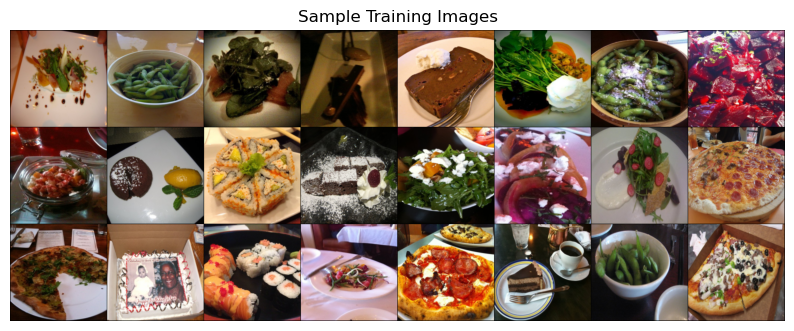

In [47]:
plot_sample_imgs(food_inputs[0:24,:,:,:])

In [48]:
Z_food = get_features(
    densenet, food_inputs, 
).numpy()

In [49]:
Z_food.shape

(350, 1024)

In [50]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_food)

KMeans(n_clusters=5, n_init='auto', random_state=123)

In [51]:
km.cluster_centers_.shape

(5, 1024)

Image indices:  [339  55  22 273  50 188]


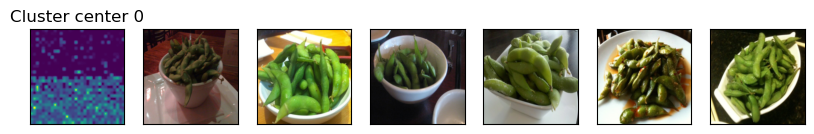

Image indices:  [181 271  80 212 326 325]


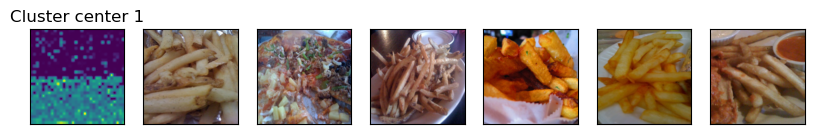

Image indices:  [253 236  63  60   0 238]


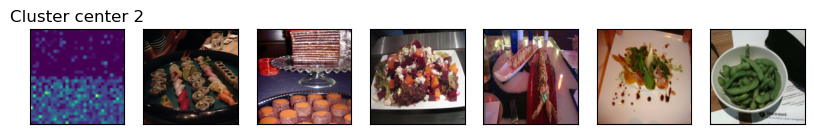

Image indices:  [116  29 122 282 201  84]


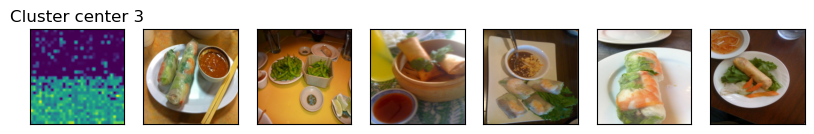

Image indices:  [223 246 118 154 184 231]


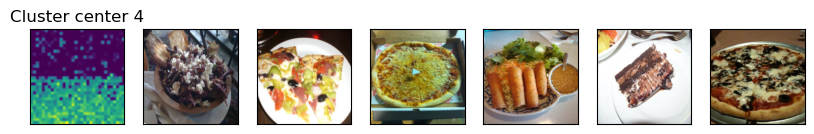

In [52]:
for cluster in range(k):
    get_cluster_images(km, Z_food, X_food, cluster, n_img=6)

There are some mis-classifications but overall it seems pretty good! You can experiment with 
- Different values for number of clusters
- Different pre-trained models
- Other possible representations 
- Different image datasets

See an example of using K-Means clustering on customer segmentation in [AppendixB](../AppendixB.ipynb).